In [15]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
sns.set('notebook')

In [16]:
def retrieve_data():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        milk = pd.read_sql_table('milk_volume', con)
        birthdates = pd.read_sql_table('birthdates', con)[['animal_id', 'birthdate']]
    return milk, birthdates
milk, birthdates = retrieve_data()

In [17]:
milk = milk.set_index('date')['2016-01-01':'2017-12-31']

In [18]:
def append_cow_age_to_milk_dataframe(milk, birthdates):
    """ Adds a cows age in month for each day milked"""
    milk = milk.reset_index()
    milk = pd.merge(left=milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    milk['months_aged'] = (milk['date'] - milk['birthdate']).astype('timedelta64[M]')
    return milk

In [19]:
milk_with_age = append_cow_age_to_milk_dataframe(milk, birthdates)

In [20]:
# Cows who are on their 1,2 lactations are assumed to be less than 36 months in age
aged_boolean_mask = milk_with_age['months_aged'] > 36
aged_cows = milk_with_age[aged_boolean_mask]
non_aged = milk_with_age[~aged_boolean_mask]

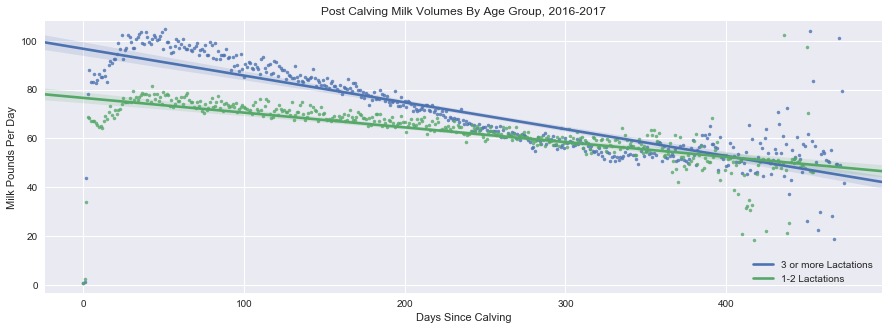

In [25]:
def plot_average_milk_volumes_after_calving(aged_cows, non_aged):
    fig, ax = plt.subplots(figsize=(15, 5))

    aged_cows = aged_cows.groupby('days_since_calving').mean().reset_index()
    ax1 = sns.regplot(aged_cows['days_since_calving'], aged_cows['milk_weight'], marker='.', ax=ax)
    _ = plt.margins(0.03)
    _ = plt.xlabel('Days Since Calving')
    _ = plt.ylabel('Milk Pounds')

    non_aged = non_aged.groupby('days_since_calving').mean().reset_index()
    ax2 = sns.regplot(non_aged['days_since_calving'], non_aged['milk_weight'], marker='.', ax=ax)
    _ = plt.margins(0.03)
    _ = plt.xlabel('Days Since Calving')
    _ = plt.ylabel('Milk Pounds Per Day')
    

    plt.legend(('3 or more Lactations', '1-2 Lactations'))
    plt.title('Post Calving Milk Volumes By Age Group, 2016-2017')
    plt.savefig('figures/average_milk_production_after_calving.png', dpi=300, bbox_inches='tight')
    plt.show()
    
plot_average_milk_volumes_after_calving(aged_cows, non_aged)

In [39]:
aged_cows_mean = aged_cows.groupby('days_since_calving').mean().reset_index()
non_aged_mean = non_aged.groupby('days_since_calving').mean().reset_index()



In [45]:
def first_days_milkweight_sum(milk, days=305):
    return  milk[milk['days_since_calving'] <= days].sum()['milk_weight']

def print_milk(weight):
    print(f'{weight} milk-pounds - {weight / 8.6} gallons')

In [46]:
aged_305 = first_days_milkweight_sum(aged_cows_mean)
print_milk(aged_305)

24435.512052522972 milk-pounds - 2841.338610758485 gallons


In [47]:
unaged_305 = first_days_milkweight_sum(non_aged_mean)
print_milk(unaged_305)

20789.28176518163 milk-pounds - 2417.3583447885617 gallons


In [48]:
aged_percent_above = (aged_305 - unaged_305) / unaged_305
aged_percent_above

0.17538991142292051